In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import datetime
import calendar
import seaborn as sns; sns.set(); sns.set_style("white")

In [3]:
%matplotlib inline

In [4]:
# Meteo stations locations
stations = pd.read_json("http://monitor.pogodynka.pl/api/map/?category=meteo")
stations = stations[['i','n','la','lo']]

In [114]:
#Loading previously saved data (Get_the_data.ipynb)
meteo_data = pd.read_pickle('IMGW_data/meteo_data_all.pickle')

I tried to choose stations that have more or less complete data but also are diverse both geographically and considering the type of location (big cities, mountains, remote areas)

In [7]:
chosen_stations = ['KARPACZ','BIAŁOWIEŻA', 'KRAKÓW-OBSERWATORIUM', 'WARSZAWA-BIELANY', 'GDYNIA','KOŚCIERZYNA','OLECKO', 'KOMAŃCZA',
                 'GDAŃSK-RĘBIECHOWO']
meteo_data_chosen = meteo_data[meteo_data['station_name'].isin(chosen_stations)]

In [9]:
meteo_data_chosen.snow_height_stat.unique()

array([nan,  9.,  8.])

8 - no measure was taken
9 - there was no phenomenon

In [11]:
meteo_data_chosen.loc[meteo_data_chosen.snow_height_stat==9].head(3)

,station_code,station_name,year,month,day,temp_max,temp_max_stat,temp_min,temp_min_stat,temp_avg,temp_avg_stat,temp_min_ground,temp_min_ground_stat,sum_prec,sum_prec_stat,prec_type,snow_height,snow_height_stat,date
742,250150220,KARPACZ,1951,1,13,6.3,NaN,-1.0,NaN,1.3,NaN,-6.4,NaN,0.0,NaN,W,0,9.0,1951-01-13
743,250150220,KARPACZ,1951,1,14,2.2,NaN,-1.9,NaN,0.8,NaN,-5.0,NaN,0.0,9.0,NaN,0,9.0,1951-01-14
744,250150220,KARPACZ,1951,1,15,2.3,NaN,-0.6,NaN,0.6,NaN,-4.2,NaN,6.0,NaN,S,0,9.0,1951-01-15


In [116]:
meteo_data_chosen=meteo_data_chosen.drop(meteo_data_chosen[(meteo_data_chosen.station_name == 'GDAŃSK-RĘBIECHOWO')& (meteo_data_chosen.year==1993)& (meteo_data_chosen.station_code ==354180150)].index)

## Snow

As we are in the time of the winter, which seems to make history with highest winter temperatures anyone remember, I'll focus on snow.

In [117]:
days_with_snow = meteo_data_chosen.loc[meteo_data_chosen.snow_height>0].groupby(['station_name','station_code','year']).count().iloc[:,1]
days_with_snow = pd.DataFrame(days_with_snow)
days_with_snow.reset_index(['station_name','year'],inplace=True)
days_with_snow.rename(columns = {'day': 'days'},inplace=True)

In [15]:
snow_amount = meteo_data_chosen.loc[meteo_data_chosen.snow_height>0].groupby(['station_name','station_code','year']).sum()
snow_amount = pd.DataFrame(snow_amount.loc[:,'snow_height'])
snow_amount.reset_index(['station_name','year'],inplace=True)

In [119]:
days_with_snow = pd.merge(days_with_snow, snow_amount, how = 'left', left_on = ['station_name','year'], 
                          right_on =['station_name','year'])
days_with_snow['snow_height_avg'] = days_with_snow.snow_height / days_with_snow.days
days_with_snow = days_with_snow.sort_values(['station_name','year'])

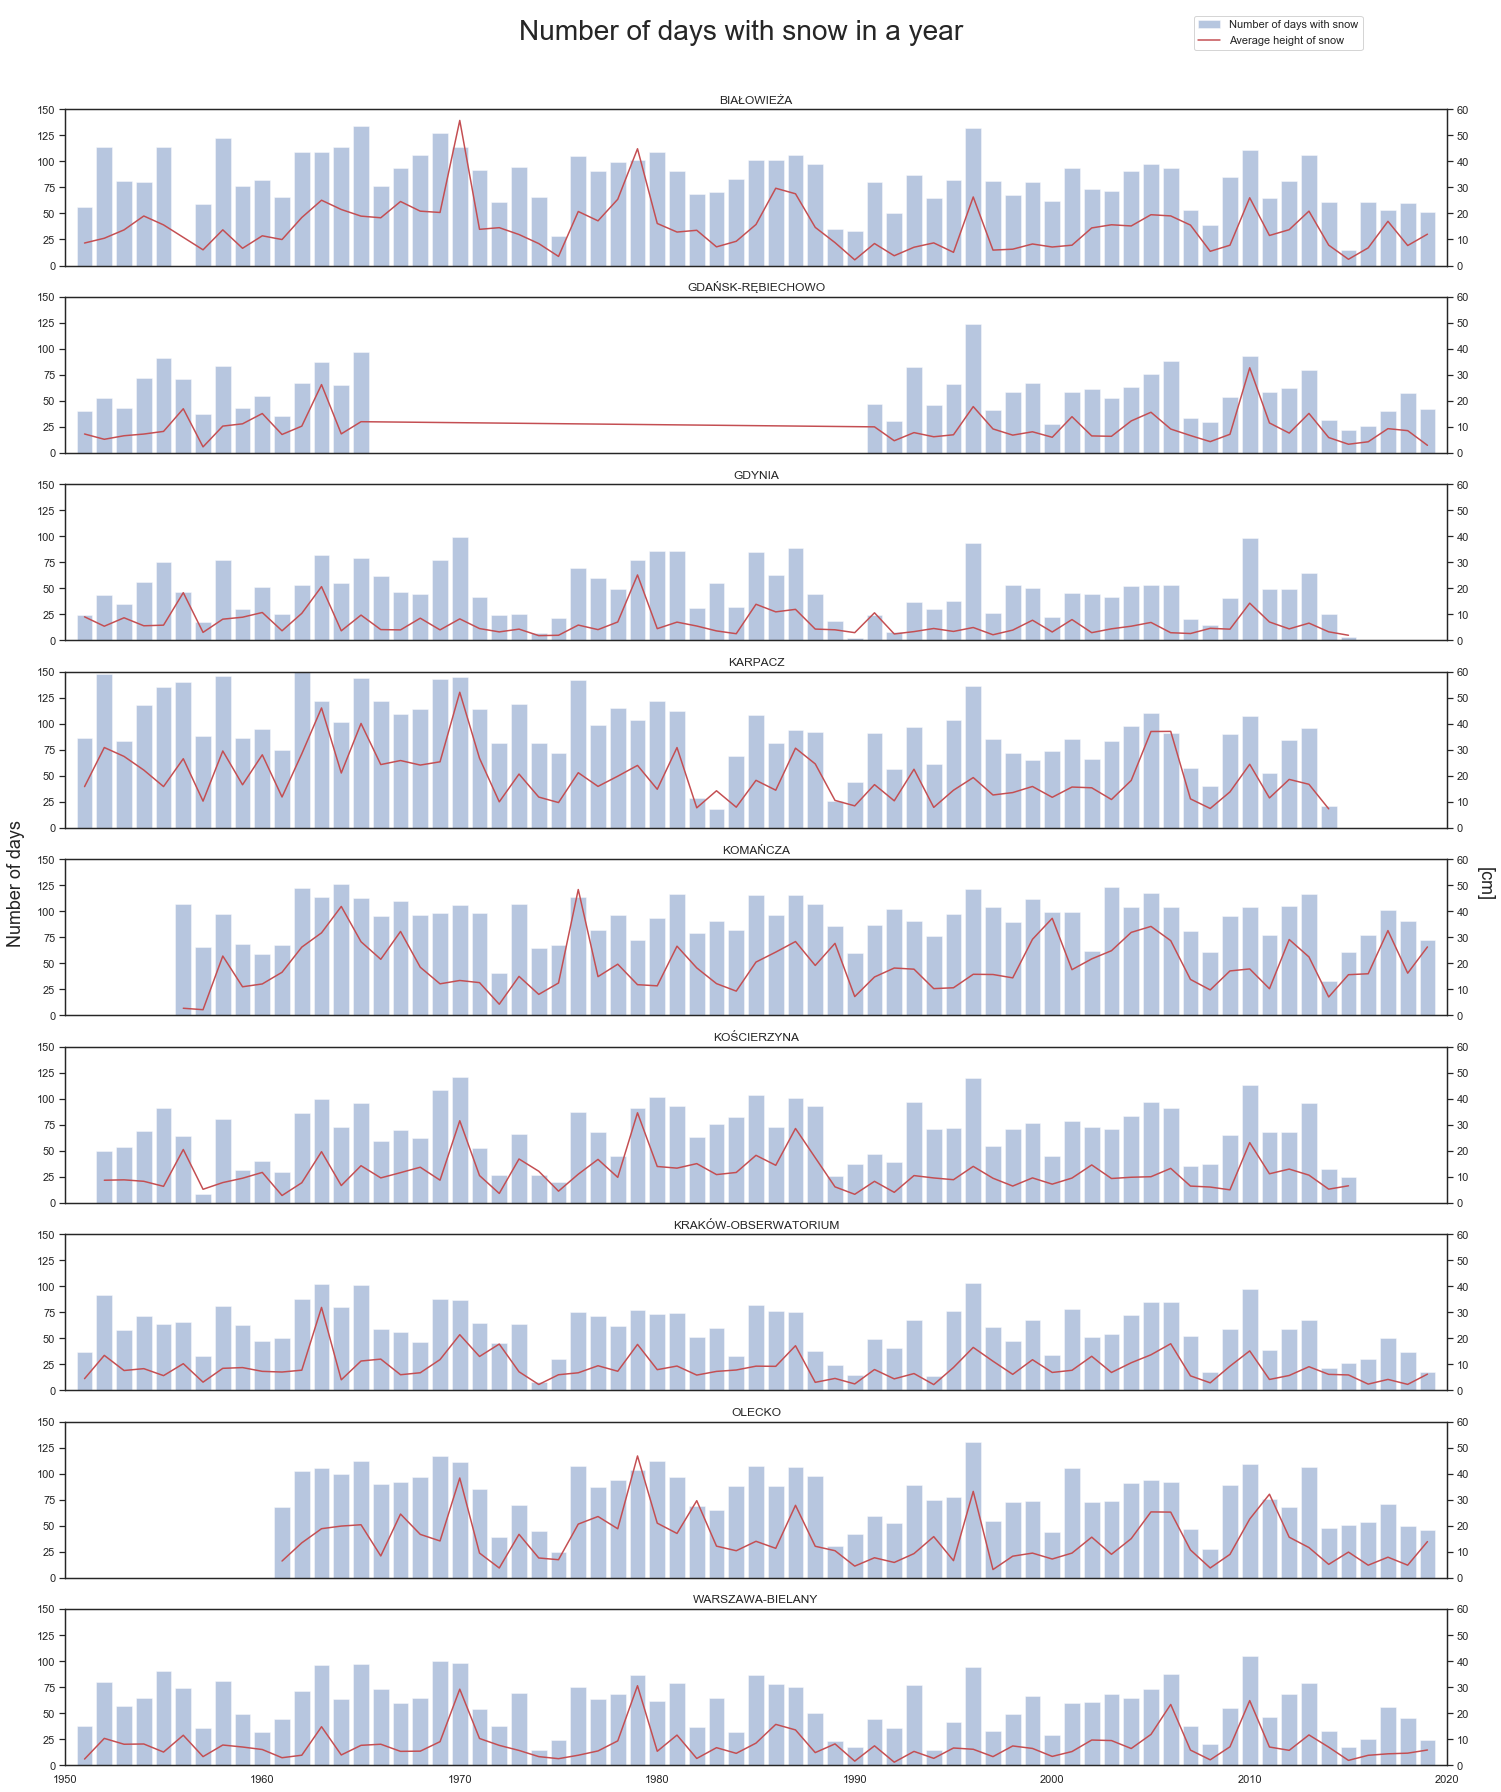

In [17]:
plt.rcParams.update({'font.size': 14})
ind = days_with_snow.station_name.unique()
fig, axes = plt.subplots(nrows = len(chosen_stations),sharex=True)
fig.text(-0.01, 0.5, 'Number of days', va='center', rotation=90,fontsize = 18)
fig.text(1.01, 0.5, "[cm]",ha='left',va='center',rotation=270,fontsize =18)
fig.suptitle('Number of days with snow in a year', fontsize=28)
fig.set_size_inches(20,25)
plt.xlim(1950,2020)
axes2=axes.copy()
cnt = 0
for i in ind:
    os_x = pd.Series(days_with_snow.loc[days_with_snow.station_name == i].year)
    os_y = pd.Series(days_with_snow.loc[days_with_snow.station_name == i].days)
    os_y2 = pd.Series(days_with_snow.loc[days_with_snow.station_name == i].snow_height_avg)
    axes[cnt].bar(os_x,os_y,alpha=0.4,label='Number of days with snow')
    axes[cnt].set_ylim([0,150])
    axes2[cnt] = axes[cnt].twinx()
    axes2[cnt].plot(os_x,os_y2,color='r',label = 'Average height of snow')
    axes2[cnt].set_ylim([0,60])
    axes[cnt].title.set_text(i)
    cnt+=1
handles, labels = axes[0].get_legend_handles_labels()
handles.append(axes2[0].get_legend_handles_labels()[0][0])
labels.append(axes2[0].get_legend_handles_labels()[1][0])
fig.legend(handles, labels,loc='upper right',bbox_to_anchor=(0.95, 0.99))
plt.subplots_adjust(bottom=0.01, top=0.93,left=0.03,right=0.99)
#plt.tight_layout()

It's hard to assess whether the situation changes, therefore I'll make a deeper analysis of Białowieża and Warszawa Bielany stations.

#### Data

In [120]:
bialowieza = days_with_snow.loc[days_with_snow.station_name == 'BIAŁOWIEŻA'].copy()
bialowieza = bialowieza.loc[:,['year','days','snow_height_avg']]
bialowieza['month'] = 1
bialowieza['day'] = 1
bialowieza['date'] = pd.to_datetime(bialowieza.loc[:,['year','month','day']],format = '%Y/%m/%d')
bialowieza_days = bialowieza.loc[:,['date','days']].set_index('date')
bialowieza_snow = bialowieza.loc[:,['snow_height_avg','date']].set_index('date')

In [121]:
warszawa = days_with_snow.loc[days_with_snow.station_name == 'WARSZAWA-BIELANY'].copy()
warszawa = warszawa.loc[:,['year','days','snow_height_avg']]
warszawa['month'] = 1
warszawa['day'] = 1
warszawa['date'] = pd.to_datetime(warszawa.loc[:,['year','month','day']],format = '%Y/%m/%d')
warszawa_days = warszawa.loc[:,['date','days']].set_index('date')
warszawa_snow = warszawa.loc[:,['snow_height_avg','date']].set_index('date')

#### ACF

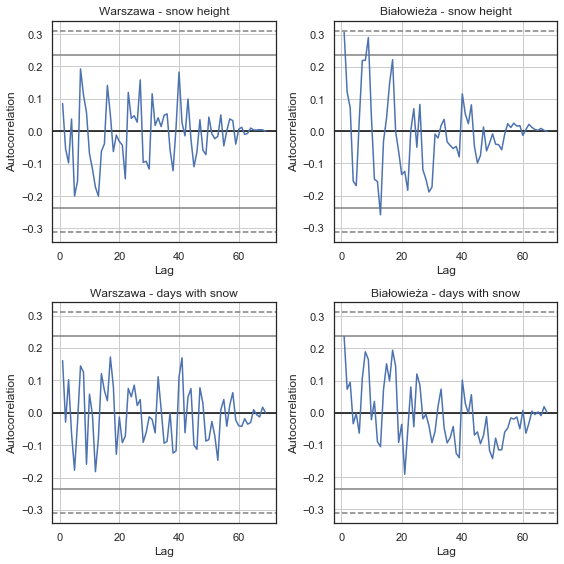

In [123]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(221)
pd.plotting.autocorrelation_plot(warszawa_snow, ax=ax1)
ax1.set_title('Warszawa - snow height')
ax2 = fig.add_subplot(222)
pd.plotting.autocorrelation_plot(bialowieza_snow, ax=ax2)
ax2.set_title('Białowieża - snow height')
ax3 = fig.add_subplot(223)
pd.plotting.autocorrelation_plot(warszawa_days, ax=ax3)
ax3.set_title('Warszawa - days with snow')
ax4 = fig.add_subplot(224)
pd.plotting.autocorrelation_plot(bialowieza_days,ax=ax4)
ax4.set_title('Białowieża - days with snow')
plt.tight_layout()

There is no autocorrelation hence there is no seasonality.

#### Moving average

In [124]:
warszawa_days['MA_10'] =  warszawa_days.days.rolling(window=10).mean()
warszawa_days['MA_30'] =  warszawa_days.days.rolling(window=30).mean()
warszawa_snow['MA_10'] =  warszawa_snow.snow_height_avg.rolling(window=10).mean()
warszawa_snow['MA_30'] =  warszawa_snow.snow_height_avg.rolling(window=30).mean()
bialowieza_snow['MA_10'] =  bialowieza_snow.snow_height_avg.rolling(window=10).mean()
bialowieza_snow['MA_30'] =  bialowieza_snow.snow_height_avg.rolling(window=30).mean()
bialowieza_days['MA_10'] =  bialowieza_days.days.rolling(window=10).mean()
bialowieza_days['MA_30'] =  bialowieza_days.days.rolling(window=30).mean()

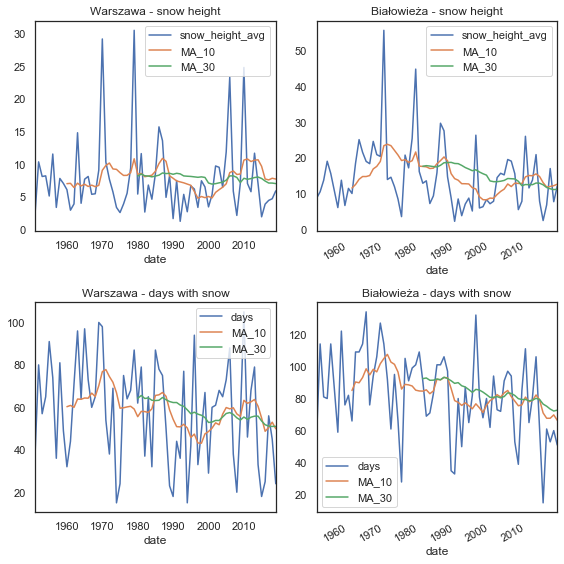

In [125]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(221)
warszawa_snow.plot(ax=ax1)
ax1.set_title('Warszawa - snow height')
ax2 = fig.add_subplot(222)
bialowieza_snow.plot(ax=ax2)
ax2.set_title('Białowieża - snow height')
ax3 = fig.add_subplot(223)
warszawa_days.plot(ax=ax3)
ax3.set_title('Warszawa - days with snow')
ax4 = fig.add_subplot(224)
bialowieza_days.plot(ax=ax4)
ax4.set_title('Białowieża - days with snow')
plt.tight_layout()

There is a visible decreasing trend in the number of days with snow in both stations.

### Last white Christmas?

In [59]:
#Limit the stations to the ones that have full data for the last few years
chosen_stations_christmas = ['BIAŁOWIEŻA', 'KRAKÓW-OBSERWATORIUM', 'WARSZAWA-BIELANY','OLECKO', 'KOMAŃCZA',
                 'GDAŃSK-RĘBIECHOWO']
meteo_data_christmas = meteo_data_chosen[meteo_data_chosen['station_name'].isin(chosen_stations_christmas)]

#White Christmas - the snow coverage of min. 5 cm is existent during all 3 of Christmas days
meteo_data_christmas = meteo_data_christmas.loc[(meteo_data_christmas.month==12) &
                                                ((meteo_data_christmas.day==24)|(meteo_data_christmas.day==25)|(meteo_data_christmas.day==26)) 
                                                & (meteo_data_christmas.snow_height>=5)]
meteo_data_christmas=pd.DataFrame(meteo_data_christmas.loc[:,['year','station_name','day']].groupby(['year','station_name']).count())
meteo_data_christmas=meteo_data_christmas.loc[meteo_data_christmas.day==3]
meteo_data_christmas = meteo_data_christmas.reset_index(['year','station_name'])
meteo_data_christmas.loc[:,['year','station_name']].groupby('station_name').max()

,year
station_name,
BIAŁOWIEŻA,2018
GDAŃSK-RĘBIECHOWO,2010
KOMAŃCZA,2018
KRAKÓW-OBSERWATORIUM,2010
OLECKO,2018
WARSZAWA-BIELANY,2010


In the big cities there was no white Christmas since 2010, but it doesn't seem to be a problem outside.

### When does it snow anyway?

There's a quite common theory that season just move to  later - it's a surprise to see white Christmas, but it's perfectly normal to see white Eastern. I'll try to capture wheter it's true.

#### Data for the chart

In [126]:
bw_days_with_snow= meteo_data.loc[((meteo_data.prec_type == 'S')|(meteo_data.prec_type=='s'))&(meteo_data.station_name=='BIAŁOWIEŻA')
              ,['year','month','day','date']]

In [127]:
bw_days_with_snow.sort_values('date',inplace=True)

In [128]:
def winter(r):
    if r['month']>=10: val=r['year']+1
    else: val = r['year']
    return val
bw_days_with_snow['winter'] = bw_days_with_snow.apply(winter, axis=1)
def day_num(r):
    return (r.date.timetuple().tm_yday + 92)%365
bw_days_with_snow['day_num'] = bw_days_with_snow.apply(day_num, axis=1)

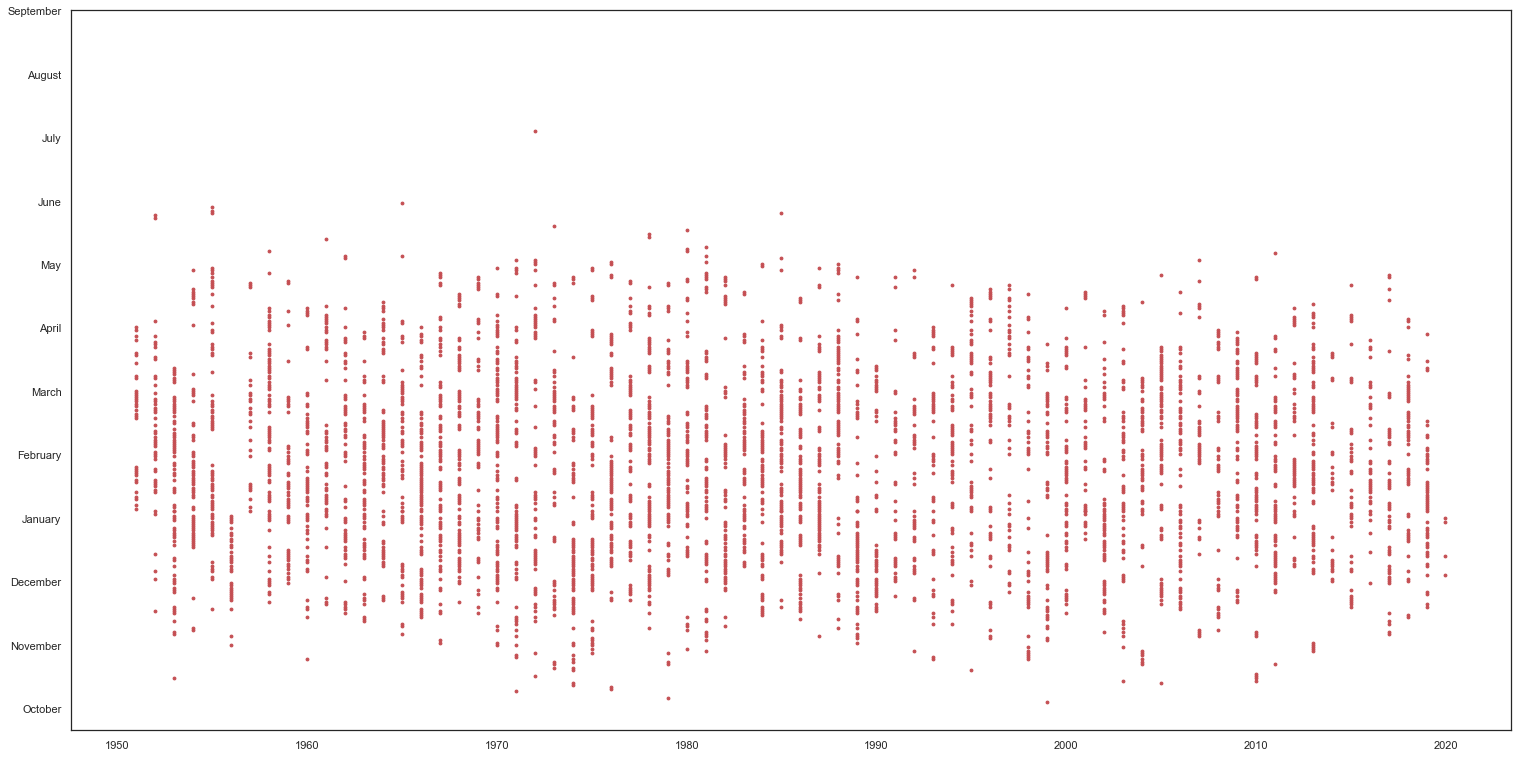

In [129]:
fig=plt.figure(figsize=[20,10])
ax=fig.add_axes([0,0,1,1])
ax.scatter(bw_days_with_snow['winter'], bw_days_with_snow['day_num'], color='r', s=8, marker='o')
plt.yticks(np.arange(360, step=30), calendar.month_name[10:13]+calendar.month_name[1:10])
plt.show()

It's not really visible that the first snow moves to later in the calendar. Seems that around 1990 snow got more sparse. But still I'll try to capture it in more, maybe better ways.

#### Heatmap

In [130]:
bw_days_with_snow_heat = bw_days_with_snow.loc[:,['day_num','winter','month']]

In [131]:
bw_days_with_snow_heat.loc[:,'month_num'] = (bw_days_with_snow_heat.month+3)%12

In [132]:
bw_snow_pivot = pd.pivot_table(bw_days_with_snow_heat,values = 'day_num',index='month_num',columns='winter',aggfunc='count')
#test.loc[:,'month_num'] = (test.month+3)%12

Text(0.5, 39.5, '')

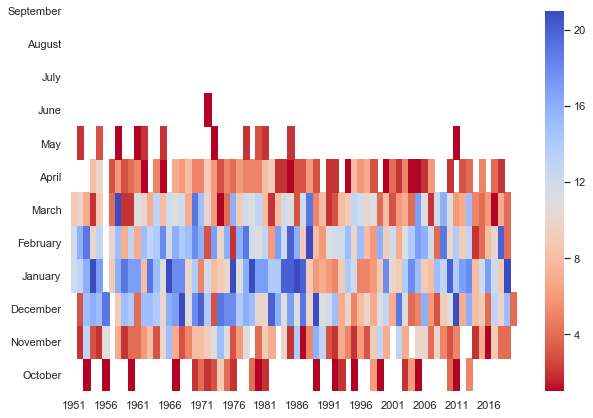

In [133]:
fig, ax = plt.subplots(figsize=(10,7))
ax = sns.heatmap(bw_snow_pivot,cmap="coolwarm_r", robust=True,
                 yticklabels=calendar.month_name[10:13]+calendar.month_name[1:10],
                xticklabels = 5)
ax.invert_yaxis()
ax.set_ylabel('')    
ax.set_xlabel('')

Again, 1990 looks like a border between the red and the blue. Seems like the first real snow really moves later into the winter, but as the result snowy time of a year gets shorter.

#### Heatmap - 2nd attempt

I'll draw a heatmap, which will show the number of days in two weeks predescant to the date during which it snowed. The darker the color, the more days. We can look at those periods as snowy (wintery) ones.

In [134]:
bialowieza = meteo_data.loc[meteo_data.station_name == 'BIAŁOWIEŻA'].copy()

In [135]:
def did_it_snow(r):
    if (r['prec_type'] == 'S') | (r['prec_type']=='s'): return 1
    else: return 0   

bialowieza['snow'] = bialowieza.apply(did_it_snow, axis=1)
bialowieza['days_with_snow_14'] = bialowieza.snow.rolling(window=14).sum()

In [137]:
bialowieza['day_num'] = bialowieza.apply(day_num, axis=1).astype('Int64')
bialowieza['winter'] = bialowieza.apply(winter, axis=1)

In [138]:
bialowieza_snow_pivot_14 = pd.pivot_table(bialowieza,values = 'days_with_snow_14',index='day_num',columns='winter',aggfunc='min')

Text(0.5, 39.5, '')

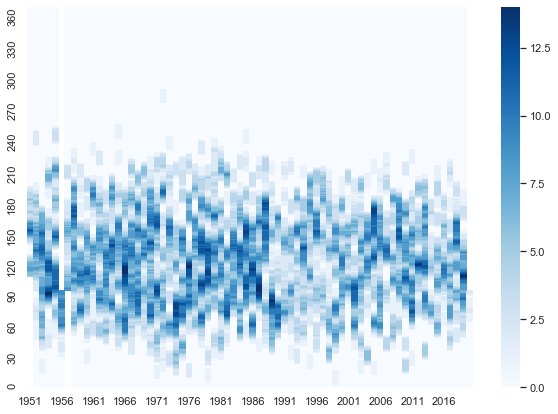

In [139]:
fig, ax = plt.subplots(figsize=(10,7))
ax = sns.heatmap(bialowieza_snow_pivot_14,cmap="Blues", 
                yticklabels = 30,
                xticklabels = 5)
ax.invert_yaxis()
ax.set_ylabel('')    
ax.set_xlabel('')

Again, it's visible that color get lighter around 1990 - meaning we see less days/periods with snowfall.